In [1]:
# add YOLO submodules as modules
import sys
import pathlib
sys.path.append(f"{pathlib.Path().absolute()}/YOLO")

# import yolo
import yolo
from PIL import Image
import cv2
import numpy as np
import pandas
import time

# change cwd to YOLO
import os
os.chdir('YOLO')

In [2]:
%%capture
# YOLO() dumps data to stdout, %%caputer will prevent printing

# Model Initialization
YOLO_model = yolo.YOLO_np()

# Model Prediction returns classes for which number 2 stands for car
ENUM_CAR_CLASS = 2

# Model return rectangle coordinates, that represents area, where object is located
# We use this constant to determine if this area is small enough to be ignored
ERROR_DEVIATION = 0.2

# Functions

### Car Detection
Function takes 1 argument:

    path: image path
    
Function determines whether car exists on picture. Car should occupie more than 20% of picture to be determined ascar picture. With True/False function return coordinates of box, where car is located in the image

In [3]:
def detect_car(path, model=YOLO_model):
    # 1. Open Image
    image = Image.open(path)
    
    # 2. Preprocessing 
    image_data = yolo.preprocess_image(image, model.model_image_size)
    #origin image shape, in (height, width) format
    image_shape = tuple(reversed(image.size))


    # 3. Prediction
    boxes, classes, scores = model.predict(image_data, image_shape)
    
    # 4. Check if car is in the detected objects
    for i in range(len(classes)):
        if classes[i] == ENUM_CAR_CLASS:
            # 4.1. If car is detected check for box area
            box = boxes[i]
            area = abs((box[2] - box[0]) * (box[3] - box[1]))
            
            # 4.2. Normalize evaluated area
            area = area/(image_shape[0]*image_shape[1])

            # 4.3. If box area is too small, we can ignore it
            if area > ERROR_DEVIATION:
                return True, box
    return False, None

### Crop Image
function takes 3 arguments:

    src_path: path where image is located
    dst_path: path where cropped image should be saved
    coordinates: box coordinates that should be cropped
    
It will check for coordinates to be inside image shape (else will scale), then it will crop image and save in the given path

In [4]:
def crop_image(src_path, dst_path, coordinates=None):
    img = cv2.imread(src_path)

    # Sanity Check for boxes to be in the given image shape
    img_height, img_width, _ =img.shape 

    if coordinates is not None:
        coordinates[0] = min(img_width - 1, max(0, coordinates[0]))
        coordinates[2] = min(img_width - 1, max(0, coordinates[2]))

        coordinates[1] = min(img_height- 1, max(0, coordinates[1]))
        coordinates[3] = min(img_height- 1, max(0, coordinates[3]))

        crop_img = img[coordinates[1]:coordinates[3],
                       coordinates[0]:coordinates[2]]
        img = crop_img
    
    # Using cv2.imwrite() method 
    # Saving the image 
    cv2.imwrite(dst_path, img)

# Testing
test iamge is already loacated in the following folder and name `test_data/car/1.jpg`. Following scripts will take thi image path as input, detect car , crop it, save it to `test_data/1_cropped.jpg` and show to user.

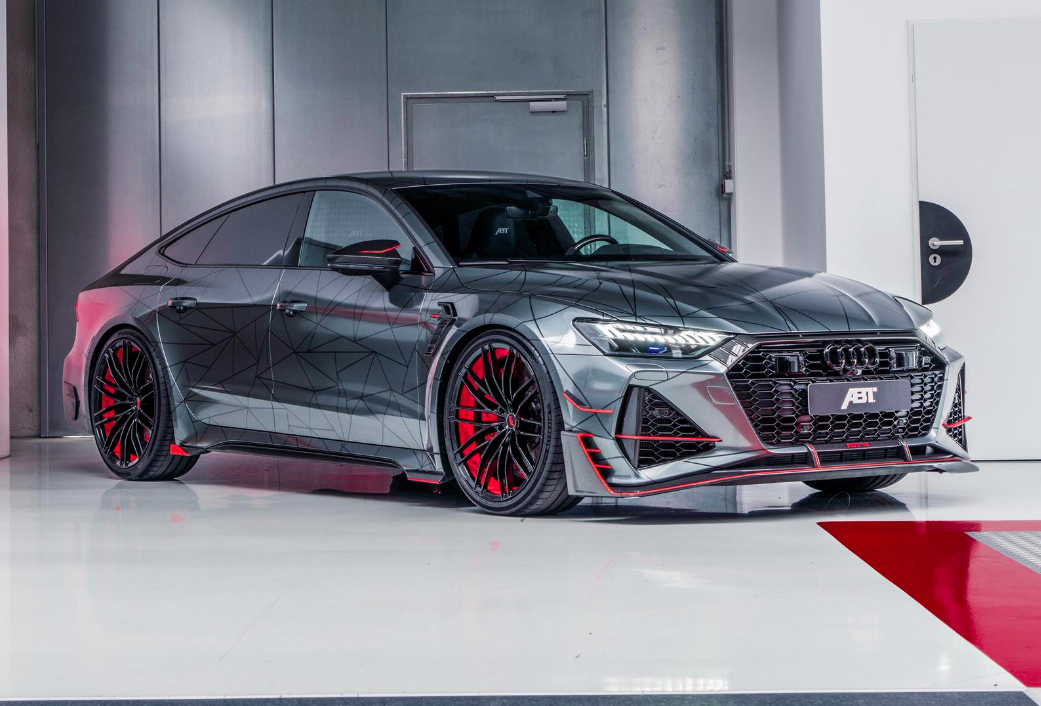

In [5]:
image_src_path = '../test_data/1.png'
image_dst_path = '../test_data/1_cropped.png'

image = Image.open(image_src_path)
image

### 1. test `detect_car()` function

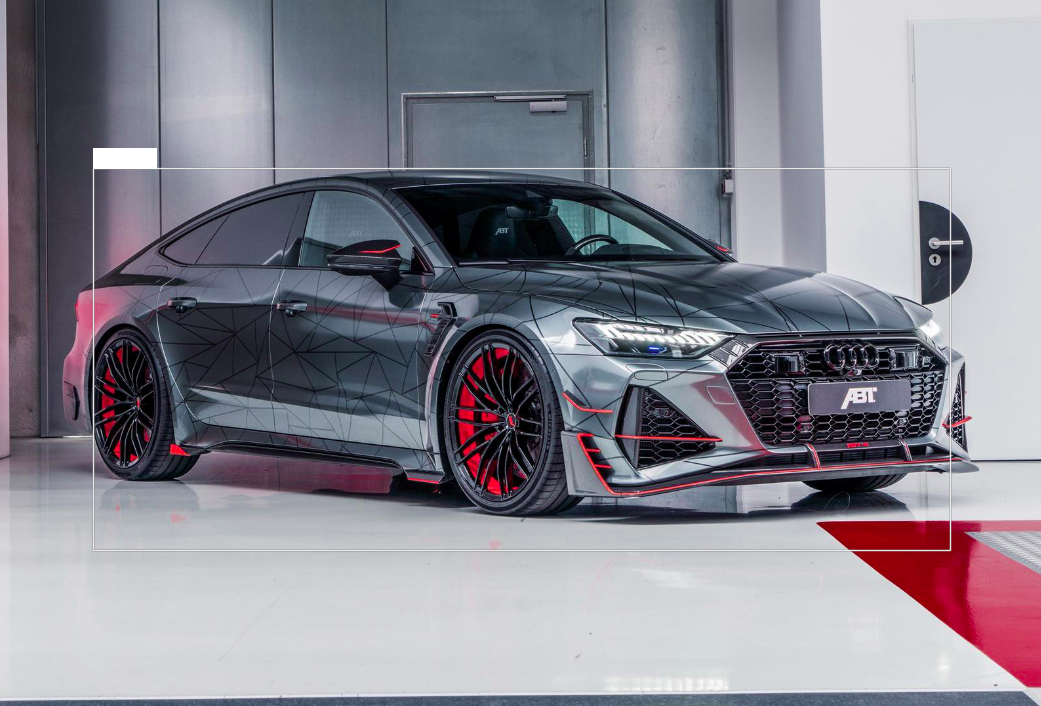

In [6]:
result, coordinates = detect_car(image_src_path)

# on image car is present, so result should be True
assert(result)
assert(len(coordinates) == 4)

# draw result with rectangle over car object
image_array = np.array(image, dtype='uint8')
image_array = yolo.draw_boxes(image_array, [coordinates], [ENUM_CAR_CLASS], [0], 'YOLO', None)
Image.fromarray(image_array)

### 2. test `crop_image()` function

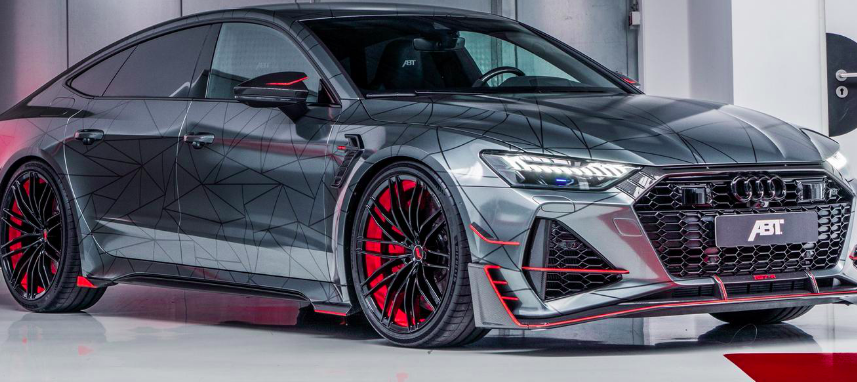

In [7]:
# Crop image over the rectangle
crop_image(image_src_path, image_dst_path, coordinates)

# Check if resulted image is cropped correctly
result_image = Image.open(image_dst_path)
result_image

# Classify images as exterior/interior


### 1. Initilize variables

In [8]:
images_dir = '../data/img_data/car_imgs'
csv_file_path = '../data/final.csv'

output_dir = '../result_data'
output_imgs_dir = '../result_data/images'

EXTERIOR = 'exterior'
INTERIOR = 'interior'

df = pandas.read_csv(csv_file_path)

In [9]:
df.head()

,ID,Manufacturer,Model,Category,Mileage,Gear box type,Doors,Wheel,Color,Interior color,VIN,Leather interior,Price,Customs
0,45628667,TOYOTA,Tacoma,Sedan,397915 km,Automatic,NaN,Left wheel,White,NaN,5TFJX4GN4DX026901,1,9100,834.0
1,45788844,TOYOTA,RAV 4,Jeep,30402 km,Variator,4/5,Left wheel,Blue,Black,NaN,0,15000,518.0
2,45653468,HONDA,Insight,Hatchback,210758 km,Automatic,4/5,Left wheel,Silver,NaN,JHMZE2H57AS029004,1,800,574.0
3,45731431,KIA,Optima,Sedan,131040 km,Tiptronic,4/5,Left wheel,White,Black,KNAGM4AD8D5052655,0,5500,751.0
4,45771182,LEXUS,ES 300,Sedan,135500 km,Tiptronic,4/5,Left wheel,White,Black,NaN,1,13500,NaN


### 2. define function to be executed for each folder

In [10]:
def func(index, row):
    # Prepare folders
    car_ID = row["ID"]
    car_dir = f"{images_dir}/{car_ID}"
    out_dir = f"{output_imgs_dir}/{car_ID}"
    
    # 1. Check if 'data/images/ID' folder exists
    if not os.path.exists(car_dir):
        return
    
    # 2. create exterior/interior specific folders
    ext_dir = f"{out_dir}/{EXTERIOR}"
    int_dir = f"{out_dir}/{INTERIOR}"
    
    # 2.1. create directory 'result/images/ID'
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    
    # 2.2. create directory 'result/images/ID/exterior'
    if not os.path.exists(ext_dir):
        os.mkdir(ext_dir)
    
    # 2.3. create directory 'result/images/ID/interior'
    if not os.path.exists(int_dir):
        os.mkdir(int_dir)
    
    # 3.iterate over each image and clasify
    for img_name in os.listdir(car_dir):
        img_path = f"{car_dir}/{img_name}"
        
        try:
            # 3.1 car detection
            result, coordinates = detect_car(img_path)

            # 3.2 car cropping/saving
            if result: # Exterior
                dst_path = f"{ext_dir}/{img_name}"
                crop_image(img_path, dst_path, coordinates)
            else:  # Interior
                dst_path = f"{int_dir}/{img_name}"
                crop_image(img_path, dst_path)
        except:
            pass

### 3. execute function for each folder

In [11]:
# create dir 'result/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# create dir 'result/images'
if not os.path.exists(output_imgs_dir):
    os.mkdir(output_imgs_dir)
    
# variables for time calculation
total_time = 0
percentage = 0.25
chunk_size = percentage * df.shape[0]//100

# Iterate over each row in df and process image
for index, row in df.iterrows():
    start_time = time.time()
    
    # function execution: START
    func(index, row)
    # function execution: END
    
    # count time
    end_time = time.time()
    elapsed = end_time - start_time
    total_time += elapsed
    
    # log
    if (index)%chunk_size == 0:
        
        time_per_row = total_time/(index+1)
        remaining = df.shape[0] - index - 1
        
        print('Done {prcntg:05.2f}%, Average time per run: {time:06.2f}s, Elapsed Time: {elap:.1f}m, Approximate Remaining Time: {rem:.1f}m'.format(
            prcntg=(index+1)* percentage/chunk_size ,
            time=time_per_row,
            elap=total_time/60,
            rem=remaining/(time_per_row*60)))

Done 00.00%, Average time per run: 1.07s, Elapsed Time: 0.0m, Approximate Remaining Time: 1339.7m
Done 00.25%, Average time per run: 0.94s, Elapsed Time: 3.4m, Approximate Remaining Time: 1520.7m
Done 00.50%, Average time per run: 0.94s, Elapsed Time: 6.7m, Approximate Remaining Time: 1522.0m
Done 00.75%, Average time per run: 0.93s, Elapsed Time: 9.9m, Approximate Remaining Time: 1534.2m
Done 01.00%, Average time per run: 0.93s, Elapsed Time: 13.2m, Approximate Remaining Time: 1532.4m
Done 01.25%, Average time per run: 0.93s, Elapsed Time: 16.5m, Approximate Remaining Time: 1527.5m
Done 01.50%, Average time per run: 0.92s, Elapsed Time: 19.8m, Approximate Remaining Time: 1527.0m
Done 01.75%, Average time per run: 0.92s, Elapsed Time: 23.1m, Approximate Remaining Time: 1522.7m
Done 02.00%, Average time per run: 0.93s, Elapsed Time: 26.5m, Approximate Remaining Time: 1514.0m
Done 02.25%, Average time per run: 0.93s, Elapsed Time: 29.8m, Approximate Remaining Time: 1510.6m
Done 02.50%, A